<a href="https://colab.research.google.com/github/Shrey-Viradiya/DiveDeep/blob/master/Prac11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning

### 18BCE259

In [1]:
!nvidia-smi

Wed May  5 15:41:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the required libraries 

In [2]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from scipy.sparse import csr_matrix
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical   

from keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt

pd.set_option('max_colwidth', 150)

## Download Data

In [3]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.02G/1.04G [00:14<00:00, 45.7MB/s]
100% 1.04G/1.04G [00:14<00:00, 75.3MB/s]


In [4]:
! unzip -n -qq flickr8k.zip

## Data loading and Preprocessing

In [5]:
captions = pd.read_csv("captions.txt")
captions

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


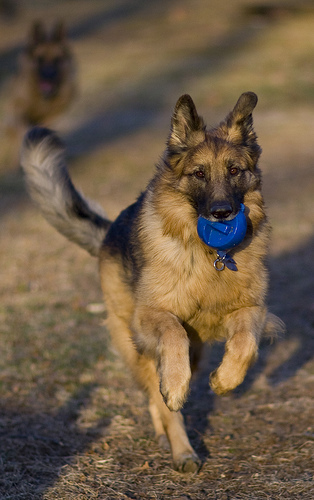

A brown and black dog fetching a blue toy .
A dog carrying something blue and running .
A dog running with a blue toy in its mouth .
A dog runs towards the camera with a blue ball in his mouth .
A young German Shepherd runs with a toy in his mouth .


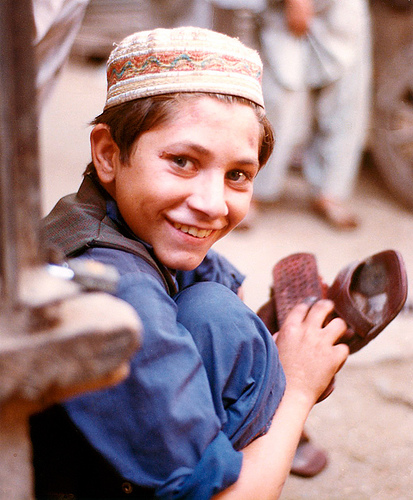

A boy sitting down smiling for the picture .
A child holding some shoes .
A child in blue and wearing a hat smiles .
A young boy smiling and holding sandals .
The boy is wearing a hat and holding sandals .


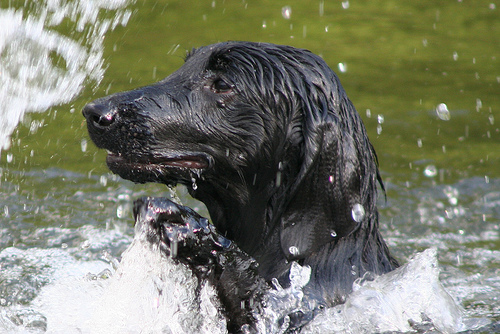

a black dog plays in the water .
A black dog 's head rises above some water .
A black dog splashes in the water .
Drenched black Labrador in the water .
The black dog 's head is poking up out of the water .


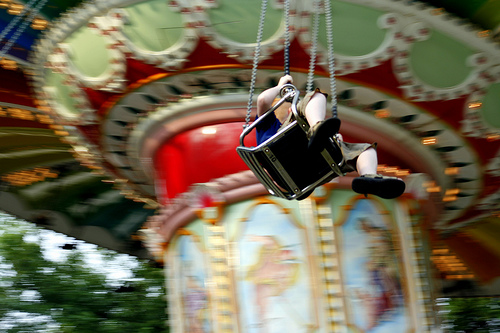

A child on an amusement park swing ride .
a lone swinger on a swing ride at the fair .
A person sits in a chair suspended by chains at an amusement park .
Kid rides high on fair swing .
Man is sitting in a swing on a carnival ride .


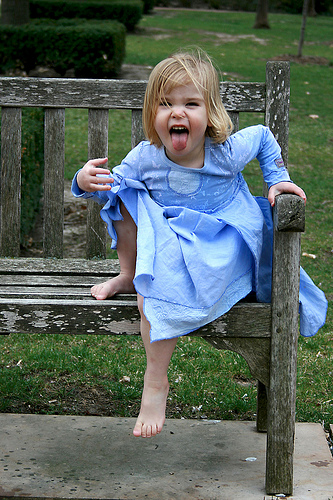

A girl sticks out her tongue on a bench .
A little girl in a blue dress sitting on a park bench , sticking out her tongue .
a little girl sticking her tongue out in a bench
The little girl in the blue dress is sitting on a wooden bench .
The little girl is sitting on an old bench and making a face


In [6]:
def display_random_data(count=5, seed=8):
    np.random.seed(seed)
    # random choose images == count
    images = np.random.choice(captions['image'].unique(), count)    
    # display and their captions
    for image in images:
        # display image
        display(Image.open(f'./Images/{image}'))
        # display caption
        img_captions = captions.loc[captions['image']==image, 'caption'].tolist()
        for cap in img_captions:
            print(cap)
display_random_data(5)

In [7]:
# constants
config = {
    'max_vocab': 10000,
    'test_ratio': 0.1,
    'batch_size': 32,
    'steps_per_epoch': 1000,
    'epochs': 10
}

In [8]:
# create the captions with start and end tag
y = captions['caption'].apply(lambda x: '<start> ' + x.lower() + ' <end>')
# tokenize the captions
tokenizer = Tokenizer(num_words=config['max_vocab'], 
                      filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                      oov_token=0)
tokenizer.fit_on_texts(y) 
sequences = tokenizer.texts_to_sequences(y)
# get constant
config['max_len'] = max([len(x) for x in sequences]) 
# pad the sequneces
sequences = pad_sequences(sequences, maxlen=config['max_len'], dtype='int32', padding='post', truncating='post', value=0)
# add sequences to the caption df
captions['sequences'] = sequences.tolist()

In [9]:
# get train/test split, with holdout = 20%
random.seed(10)
test_indices = random.sample(list(captions.index), int(config['test_ratio']*captions.shape[0]))
train_indices = [x for x in list(captions.index) if x not in test_indices]

In [10]:
# create datagenerator
def data_generator(pick_from_caption_indices, batch_size=32, reproduce=False):
    while True:
        img_2_arrs, one_hot_captions = [], []
        # get the indices
        if reproduce:
            random.seed(1)
        indices = random.sample(pick_from_caption_indices, batch_size)
        # get the relevant rows
        df = captions.loc[indices, ['image', 'sequences']]
        # for each batch size
        for row in df.to_dict(orient='records'):
            # load the image
            image = load_img(f"./Images/{row['image']}", color_mode="rgb", target_size=(229, 229, 3))
            img_2_arr = img_to_array(image) / 255
            one_hot_caption = to_categorical(row['sequences'], num_classes=config['max_vocab'])    
            # append
            img_2_arrs.append(img_2_arr)
            one_hot_captions.append(one_hot_caption)
        # return
        yield np.array(img_2_arrs), np.array(one_hot_captions)

# create the data generators
train_data_gen = data_generator(train_indices, config['batch_size'])
test_data_gen = data_generator(test_indices, 5, True)

## Model creation

In [11]:
# start
model = models.Sequential()
# CNN part
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(229, 229, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Flatten
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# NLP part
model.add(layers.RepeatVector(config['max_len']))
model.add(layers.LSTM(256, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(config['max_vocab'], activation='softmax')))
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 227, 227, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        4

In [12]:
# define the callbacks
checkpoint = ModelCheckpoint("checkpoint_model_{epoch:02d}.hdf5", monitor='loss', verbose=1,
    save_best_only=False, mode='auto', save_freq=10)
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# compile the model
model.compile(optimizer='adam', loss="categorical_crossentropy")

# fit the model
history = model.fit(train_data_gen, 
                    epochs=config['epochs'],
                    steps_per_epoch=config['steps_per_epoch'],
                    verbose=1, 
                    callbacks=[checkpoint, earlystopping]
                   )

Epoch 1/10
  10/1000 [..............................] - ETA: 3:41 - loss: 8.9953
Epoch 00001: saving model to checkpoint_model_01.hdf5
  20/1000 [..............................] - ETA: 3:56 - loss: 8.1350
Epoch 00001: saving model to checkpoint_model_01.hdf5
  30/1000 [..............................] - ETA: 4:01 - loss: 7.2684
Epoch 00001: saving model to checkpoint_model_01.hdf5
  40/1000 [>.............................] - ETA: 4:01 - loss: 6.6108
Epoch 00001: saving model to checkpoint_model_01.hdf5
  50/1000 [>.............................] - ETA: 4:00 - loss: 6.1167
Epoch 00001: saving model to checkpoint_model_01.hdf5
  60/1000 [>.............................] - ETA: 3:59 - loss: 5.7350
Epoch 00001: saving model to checkpoint_model_01.hdf5
  70/1000 [=>............................] - ETA: 3:56 - loss: 5.4309
Epoch 00001: saving model to checkpoint_model_01.hdf5
  80/1000 [=>............................] - ETA: 3:54 - loss: 5.1819
Epoch 00001: saving model to checkpoint_model_01.hd

## Plot the history 

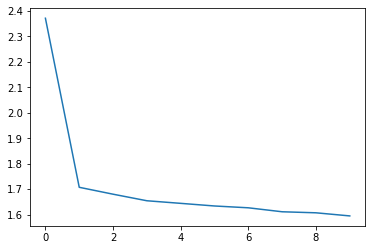

In [13]:
plt.plot(history.history['loss'])

## Test

Here Results are not very good, as it is not trained for long enough

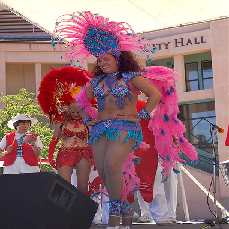

Caption: 
 <start> a young in a a a a a # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


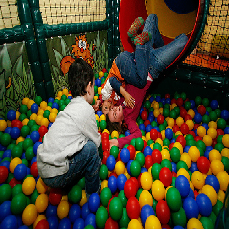

Caption: 
 <start> a young in a a a a a # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


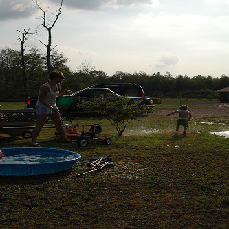

Caption: 
 <start> a man is a a a a # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


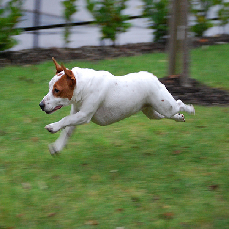

Caption: 
 <start> a dog dog dog a a a <end> # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


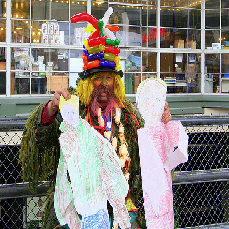

Caption: 
 <start> a young in a a a a a # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


In [14]:
# get a sample image
imgs, one_hots = next(test_data_gen)
# perform predction
predicted = model.predict(imgs)
# for each 
for i, (img, pred) in enumerate(zip(imgs, predicted)):
    # display the image
    display(array_to_img(img))
    # one hot to sentence
    sent = " ".join([tokenizer.index_word.get(np.argmax(x), '#') for x in pred])
    print("Caption: \n", sent)